In [1]:
import pytorch_ltn.ltn_models as ltn
from pytorch_ltn.optim import OptimisationTask
from pytorch_ltn.syntax import Forall, Exists, Equiv, Implies, And, Or, Not, SyntaxBackend
SyntaxBackend.UNIVERSAL_AGGREG = "min"
SyntaxBackend.EXISTENTIAL_AGGREG = "max"
SyntaxBackend.TNORM = "prod"

import torch

import numpy as np
import matplotlib.pyplot as plt

def show_result():
    x0 = data[:, 0]
    x1 = data[:, 1]
    prC = [C[i](x)() for i in clst_ids]
    n = 2
    m = (nr_of_clusters + 1) // n + 1

    fig = plt.figure(figsize=(3 * 3, m * 3))

    fig.add_subplot(m, n, 1)
    plt.title("groundtruth")
    for \
            i in clst_ids:
        plt.scatter(cluster[i][:, 0], cluster[i][:, 1])
    for i in clst_ids:
        fig.add_subplot(m, n, i + 2)
        plt.title("C" + str(i) + "(x)")
        plt.scatter(x0, x1, c=prC[i].t().detach()[0])
        plt.scatter(x0[:2], x1[:2], s=0, c=[0, 1])
        plt.colorbar()
    plt.show()

In [2]:
# loading data

nr_of_clusters = 4
nr_of_points_x_cluster = 50
clst_ids = range(nr_of_clusters)

mean = np.random.uniform([-1,-1],[1,1],(nr_of_clusters,2)).astype(np.float32)

cov = np.array([[[.01,0],[0,.01]]]*nr_of_clusters)

cluster = {}
for i in clst_ids:
    cluster[i] = np.random.multivariate_normal(mean=mean[i],cov=cov[i],size=nr_of_points_x_cluster).astype(np.float32)

data  = np.concatenate([cluster[i] for i in clst_ids])
closed_data = np.array([np.concatenate([data[i],data[j]])
                             for i in range(len(data))
                             for j in range(i,len(data))
                             if np.sum(np.square(data[i]-data[j])) < np.square(.5)])

closed_data = closed_data[np.random.random_integers(0,len(data),1000)]
distant_data = np.array([np.concatenate([data[i],data[j]])
                             for i in range(len(data))
                             for j in range(len(data))
                             if np.sum(np.square(data[i]-data[j])) > np.square(1.)])

/home/hstro/anaconda3/envs/pyt-py36/lib/python3.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: This function is deprecated. Please call randint(0, 200 + 1) instead


In [3]:
# defining the language

x = ltn.Variable("x",data=data)
y = ltn.Variable("y",data=data)
closed_x_y = ltn.Variable("closed_x_y",data=closed_data)
distant_x_y = ltn.Variable("distant_x_y",data=distant_data)

In [4]:
data.shape

(200, 2)

In [5]:

# relational predicates
rel_pre_params = {
    'k_depth' : 4
}
C = {i:ltn.Predicate("C_"+str(i), 2, 1, params=rel_pre_params) for i in clst_ids}


In [6]:
#first = ltn.Function("first",function=lambda d:d[:,:2])
#second = ltn.Function("second",function=lambda d:d[:,2:])

first_closed = ltn.Variable('first_closed', data=closed_x_y.data[:, :2])
second_closed = ltn.Variable('second_closed', data=closed_x_y.data[:, :2])
first_distant = ltn.Variable('first_distant', data=distant_x_y.data[:, :2])
second_distant = ltn.Variable('second_distant', data=distant_x_y.data[:, :2])

print("defining the theory T")
clauses = [Forall(x,Or(*[C[i](x) for i in clst_ids]))] +\
        [Exists(x,C[i](x)) for i in clst_ids] +\
        [Forall(closed_x_y,Equiv(C[i](first_closed),C[i](second_closed))) for i in clst_ids] +\
        [Forall(distant_x_y, Not(And(C[i](first_distant),(C[i](second_distant))))) for i in clst_ids] +\
        [Forall(x,Not(And(C[i](x),C[j](x)))) for i in clst_ids for j in clst_ids if i != j]

defining the theory T


In [7]:
optim_params = {
    'lr': 0.07
}
model_parameters = []
for p in C.values():
    model_parameters += p.pred.parameters() #list(p.pred.parameters())

In [8]:
task = OptimisationTask(clauses, model_parameters, optim_type='adam', params=optim_params)

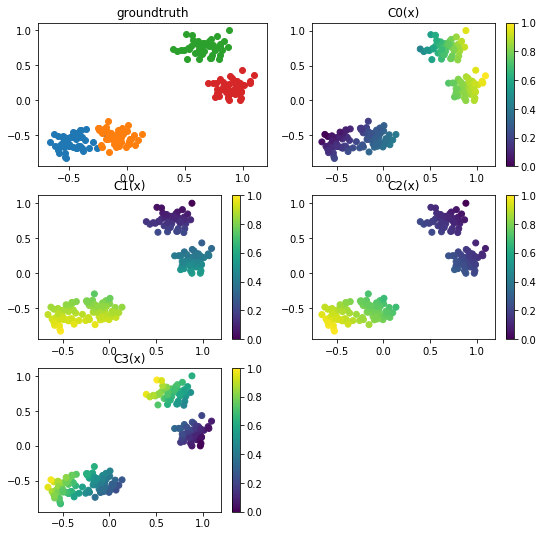

0 ----> 0.7351102232933044
100 ----> 0.8395105004310608
200 ----> 0.8398472666740417
300 ----> 0.8399195075035095
400 ----> 0.8399482369422913
500 ----> 0.8399643301963806
600 ----> 0.8399732112884521
700 ----> 0.8399794101715088
800 ----> 0.8399834036827087
900 ----> 0.8399863839149475


In [ ]:
# setting the learnign parameters

# Lambda = 1e-3
# reg_term = Lambda*tf.reduce_sum(tf.stack([tf.norm(p) for i in clst_ids for p in C[i].pars]))

# Start Learning by optimizing the satisfiability of T:

show_result()
for i in range(10000):
    sat_level = task.step()
    if i % 100 == 0:
        print(i,"---->",-sat_level)
        if -sat_level > .999:
            break

show_result()

In [ ]:
show_result()